In [1]:
from itertools import combinations
import matplotlib
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sys

module_path = os.path.abspath(os.path.join('..'))
if not module_path in sys.path:
    sys.path.insert(0, module_path)

from innoprod.sheet_tools import get_sheet_dfs
from innoprod.wrangling.msyh_data_sharing import wrangle_roadmaps, wrangle_grants

In [2]:
data = get_sheet_dfs()
roadmaps_df = wrangle_roadmaps(data['Roadmaps'])
grants_df = wrangle_grants(data['Grants'])

In [3]:
grants_totals = grants_df[['Client ID', 'Actual amount claimed']].groupby('Client ID').sum()
grants_totals = grants_totals.rename(columns={'Actual amount claimed': 'Total actual amount claimed'})

roadmaps_df = roadmaps_df.join(grants_totals, on='Client ID')

In [4]:
correlatable_cols = [col for col in roadmaps_df.columns if roadmaps_df[col].dtype not in ['str', 'datetime64[us]', 'category']]
factorisable_cols = ['Org Size by Number of FTE (calc)', 'Would you recommend the Programme to others?']
correlatable_cols += factorisable_cols
correlatable_df = roadmaps_df[correlatable_cols]

correlatable_df = correlatable_df.rename(columns={
    'Current Digital Readiness Score (refer to PAS:1040)' : 'Current DRS',
    'Anticipated resulting Digital Readiness Score (refer to PAS:1040)' : 'Anticipated DRS',
    'Do you have a Digital Champion in place?': 'Digital Champion',
    'How did you find the process of accessing the programme?': 'Programme access ease',
    'How valuable did you find the involvement of your contact within the programme during the course of the support?': 'Contact involvement value',
    'How valuable did you find the GROWTHmapper and its report in identifying the key areas of supporting your business?': 'GROWTHmapper value',
    'How valuable did you find the support you received from the Expert Coach during the course of the programme?': 'Expert Coach support value',
    'To what extent were you satisfied with the Programme overall?': 'Overall Programme satisfaction',
    'Would you recommend the Programme to others?': 'Would recommend Programme',
    'Has resource consumption (electricity, gas, waste, and water) or Greenhouse Gas emissions reduced since you started working with the Programme?': 'Consumption or GHGs reduced',
    'Increased TO/Employee': 'Increased TO per Employee'
})
factorisable_cols[1] = 'Would recommend Programme'

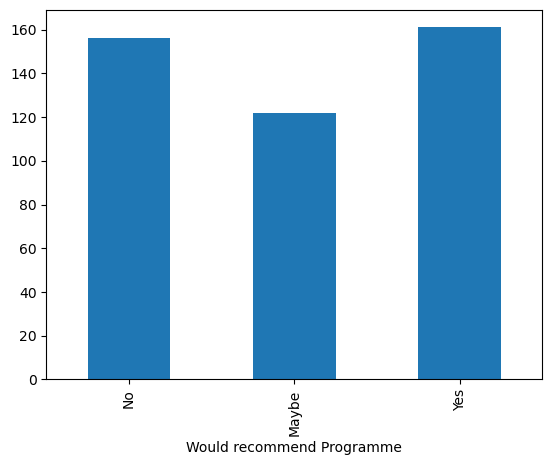

In [5]:
for col in correlatable_df.columns:
    ax = correlatable_df[col].value_counts().sort_index().plot.bar()
    fig = ax.get_figure()
    fig.savefig(f'outputs/{col}_distribution.png')

In [6]:
for col in factorisable_cols:
    codes, uniques = pd.factorize(correlatable_df[col])
    correlatable_df[col] = codes
pairwise_pearson_corrs = correlatable_df.corr()
pairwise_pearson_corrs.to_csv('outputs/pairwise_pearson_corrs.csv')

# Current vs anticipated DRS

In [7]:
drs_df = correlatable_df[['Current DRS', 'Anticipated DRS']].dropna()
x = drs_df['Current DRS'].values.reshape(-1, 1)
y = drs_df['Anticipated DRS'].values.reshape(-1, 1)
drs_curr_anticip = LinearRegression()
drs_curr_anticip.fit(x, y)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [8]:
def rand_jitter(arr, stdev=None):
    if stdev is None:
        stdev = .01 * (max(arr) - min(arr))
    r = np.random.randn(len(arr),1)
    r = r * stdev
    return arr.astype('float') + r

(0.5, 9.5)

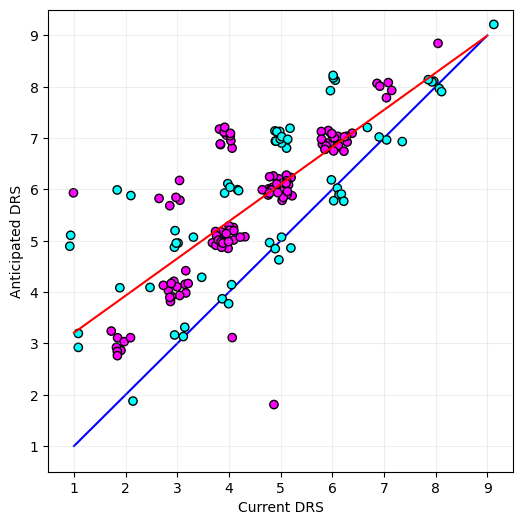

In [9]:
fig, ax = matplotlib.pyplot.subplots(figsize=(6,6))
ax.grid(visible=True, alpha=0.2, zorder=-2)

ax.plot([1,9], [1,9], zorder=-1, c='b')

stdev = 0.15
ax.scatter(rand_jitter(x, stdev=stdev), rand_jitter(y, stdev=stdev), c=((x+y)%2), edgecolor='k', cmap='cool', zorder=0)

x_range = pd.array([x.min(), x.max()], dtype="Int64").reshape(-1, 1)
ax.plot(x_range, drs_curr_anticip.predict(x_range), zorder=1, c='r')

ax.set_xlabel('Current DRS')
ax.set_xticks(np.arange(1, 10, 1))
ax.set_xlim(left=0.5, right=9.5)
ax.set_ylabel('Anticipated DRS')
ax.set_yticks(np.arange(1, 10, 1))
ax.set_ylim(bottom=0.5, top=9.5)

# Increase in productivity from investment
Comparing **Increased Turnover per Employee** ot the **Total actual amount claimed**.

In [10]:
focal_df = correlatable_df[['Total actual amount claimed', 'Increased TO per Employee']].dropna()

We only have this many clients where values are recorded for both:

In [11]:
focal_df.shape[0]

8

In [12]:
x = focal_df['Total actual amount claimed'].values.reshape(-1, 1)
y = focal_df['Increased TO per Employee'].values.reshape(-1, 1)
model = LinearRegression()
model.fit(x, y)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


<Axes: xlabel='Total actual amount claimed', ylabel='Increased TO/Employee'>

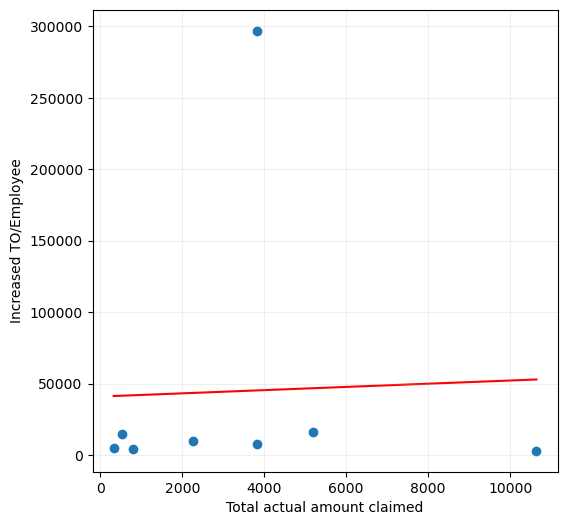

In [13]:
fig, ax = matplotlib.pyplot.subplots(figsize=(6,6))
ax.grid(visible=True, alpha=0.2, zorder=-2)

stdev = 0.15
ax.scatter(rand_jitter(x, stdev=stdev), y, zorder=0)

x_range = pd.array([x.min(), x.max()]).reshape(-1, 1)
ax.plot(x_range, model.predict(x_range), zorder=1, c='r')

ax.set_xlabel('Total actual amount claimed')
ax.set_ylabel('Increased TO/Employee')
ax